In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/csic-2010-attack-dataset-v2/csic_2010_attack_dataset_v2.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn import base
from collections import Counter
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from time import time
import logging


In [3]:
df = pd.read_csv('/kaggle/input/csic-2010-attack-dataset-v2/csic_2010_attack_dataset_v2.csv')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223585 entries, 0 to 223584
Data columns (total 18 columns):
index             223585 non-null int64
method            223585 non-null object
url               223585 non-null object
protocol          223585 non-null object
userAgent         223585 non-null object
pragma            223585 non-null object
cacheControl      223585 non-null object
accept            223585 non-null object
acceptEncoding    223585 non-null object
acceptCharset     223585 non-null object
acceptLanguage    223585 non-null object
host              223585 non-null object
connection        223585 non-null object
contentLength     100135 non-null float64
contentType       100135 non-null object
cookie            223585 non-null object
payload           198094 non-null object
label             223585 non-null object
dtypes: float64(1), int64(1), object(16)
memory usage: 30.7+ MB


In [5]:
df.head()

,index,method,url,protocol,userAgent,pragma,cacheControl,accept,acceptEncoding,acceptCharset,acceptLanguage,host,connection,contentLength,contentType,cookie,payload,label
0,0,GET,http://localhost:8080/tienda1/publico/anadir.jsp,HTTP/1.1,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,close,NaN,NaN,JSESSIONID=B92A8B48B9008CD29F622A994E0F650D,id=2,anom
1,0,GET,http://localhost:8080/tienda1/publico/anadir.jsp,HTTP/1.1,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,close,NaN,NaN,JSESSIONID=B92A8B48B9008CD29F622A994E0F650D,nombre=Jam%F3n+Ib%E9rico,anom
2,0,GET,http://localhost:8080/tienda1/publico/anadir.jsp,HTTP/1.1,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,close,NaN,NaN,JSESSIONID=B92A8B48B9008CD29F622A994E0F650D,precio=85,anom
3,0,GET,http://localhost:8080/tienda1/publico/anadir.jsp,HTTP/1.1,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,close,NaN,NaN,JSESSIONID=B92A8B48B9008CD29F622A994E0F650D,cantidad=%27%3B+DROP+TABLE+usuarios%3B+SELECT+...,anom
4,0,GET,http://localhost:8080/tienda1/publico/anadir.jsp,HTTP/1.1,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,close,NaN,NaN,JSESSIONID=B92A8B48B9008CD29F622A994E0F650D,B1=A%F1adir+al+carrito,anom


In [6]:
def _classEncoder(class_label):
    if class_label=="anom":
        return 1
    return 0

In [7]:
df['label']=df['label'].apply(_classEncoder)

In [8]:
X=df.drop(['label'], axis=1)
X=X.drop(['index'], axis=1)
y=df['label']

**Data Distribution**

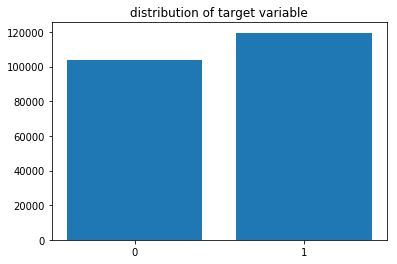

In [9]:
x=y.value_counts()
plt.bar(x.index,x)
plt.gca().set_xticks([0,1])
plt.title('distribution of target variable')
plt.show()

**Splitting the Train and Test Data**

In [10]:
def Train_Test_Split(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.35, stratify=y)
    print("y_train - ", Counter(y_train))
    print("y_test - ", Counter(y_test))
    return X_train, X_test, y_train, y_test

In [11]:
X_train, X_test, y_train, y_test = Train_Test_Split(X,y)

y_train -  Counter({1: 77730, 0: 67600})
y_test -  Counter({1: 41855, 0: 36400})


**Label Encoding**

In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
print(X.isna().sum())
X['contentLength'] = X['contentLength'].fillna(0)
X = X.replace(np.nan, '', regex=True)
# X['contentType'] = X['contentType'].fillna(None)
# X['payload'] = X['payload'].fillna(None)
print(X.isna().sum())
# for c in X.columns:
#     print(c, X[c].isna().sum())

method                 0
url                    0
protocol               0
userAgent              0
pragma                 0
cacheControl           0
accept                 0
acceptEncoding         0
acceptCharset          0
acceptLanguage         0
host                   0
connection             0
contentLength     123450
contentType       123450
cookie                 0
payload            25491
dtype: int64
method            0
url               0
protocol          0
userAgent         0
pragma            0
cacheControl      0
accept            0
acceptEncoding    0
acceptCharset     0
acceptLanguage    0
host              0
connection        0
contentLength     0
contentType       0
cookie            0
payload           0
dtype: int64


In [14]:
X_train, X_test, y_train, y_test = Train_Test_Split(X,y)

y_train -  Counter({1: 77730, 0: 67600})
y_test -  Counter({1: 41855, 0: 36400})


In [15]:
print(type(X_test))

<class 'pandas.core.frame.DataFrame'>


In [16]:
train=pd.DataFrame()
label=LabelEncoder()
for c in X.columns:
    if X[c].dtype=='object':
#         train[c] = pd.to_numeric(X[c], errors='coerce')
        train[c]=label.fit_transform(X[c])
    else:
        train[c]=X[c]

train.head(3)

,method,url,protocol,userAgent,pragma,cacheControl,accept,acceptEncoding,acceptCharset,acceptLanguage,host,connection,contentLength,contentType,cookie,payload
0,0,1214,0,0,0,0,0,0,0,0,0,0,0.0,0,44254,17162
1,0,1214,0,0,0,0,0,0,0,0,0,0,0.0,0,44254,22934
2,0,1214,0,0,0,0,0,0,0,0,0,0,0.0,0,44254,31313


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223585 entries, 0 to 223584
Data columns (total 16 columns):
method            223585 non-null int64
url               223585 non-null int64
protocol          223585 non-null int64
userAgent         223585 non-null int64
pragma            223585 non-null int64
cacheControl      223585 non-null int64
accept            223585 non-null int64
acceptEncoding    223585 non-null int64
acceptCharset     223585 non-null int64
acceptLanguage    223585 non-null int64
host              223585 non-null int64
connection        223585 non-null int64
contentLength     223585 non-null float64
contentType       223585 non-null int64
cookie            223585 non-null int64
payload           223585 non-null int64
dtypes: float64(1), int64(15)
memory usage: 27.3 MB


In [18]:
print('train data set has got {} rows and {} columns'.format(train.shape[0],train.shape[1]))

train data set has got 223585 rows and 16 columns


**Logistic Regression**

In [19]:
def logistic(X_train, X_test, y_train, y_test, C=0.0001, max_iter=100):
    lr = LogisticRegression(C=C, max_iter=max_iter)
    lr.fit(X_train,y_train)
    y_predict = np.array(lr.predict_proba(X_test)[:, 1])
    return y_test, y_predict, lr

In [20]:
def model_stats(TP, TN, FP, FN):
    sensitivity=TP/float(TP+FN)
    specificity=TN/float(TN+FP)
    print('The acuuracy of the model = TP+TN/(TP+TN+FP+FN) = ',(TP+TN)/float(TP+TN+FP+FN),'\n',

    'The Missclassification = 1-Accuracy = ',1-((TP+TN)/float(TP+TN+FP+FN)),'\n',

    'Sensitivity or True Positive Rate = TP/(TP+FN) = ',TP/float(TP+FN),'\n',

    'Specificity or True Negative Rate = TN/(TN+FP) = ',TN/float(TN+FP),'\n',

    'Positive Predictive value = TP/(TP+FP) = ',TP/float(TP+FP),'\n',

    'Negative predictive Value = TN/(TN+FN) = ',TN/float(TN+FN),'\n',

    'Positive Likelihood Ratio = Sensitivity/(1-Specificity) = ',sensitivity/(1-specificity),'\n',

    'Negative likelihood Ratio = (1-Sensitivity)/Specificity = ',(1-sensitivity)/specificity)


In [21]:
X_train, X_test, y_train, y_test = Train_Test_Split(train,y)

y_train -  Counter({1: 77730, 0: 67600})
y_test -  Counter({1: 41855, 0: 36400})


In [22]:
y_true, y_predict, _ = logistic(X_train, X_test, y_train, y_test)

roc score;  0.5863002969435295
[array([0.        , 0.        , 0.        , ..., 0.99994505, 1.        ,
       1.        ]), array([0.00000000e+00, 2.38920081e-05, 7.97993071e-03, ...,
       9.94337594e-01, 9.94337594e-01, 1.00000000e+00]), array([1.85621483, 0.85621483, 0.69609142, ..., 0.4280588 , 0.42804847,
       0.42149712])]
optimal_threshold:  0.4639794134766008
tn:  10603 fp:  25797 fn:  6288 tp:  35567
[[10603 25797]
 [ 6288 35567]]


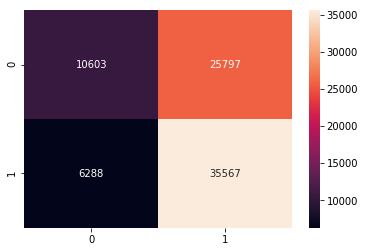

The acuuracy of the model = TP+TN/(TP+TN+FP+FN) =  0.5899942495687176 
 The Missclassification = 1-Accuracy =  0.4100057504312824 
 Sensitivity or True Positive Rate = TP/(TP+FN) =  0.849767052920798 
 Specificity or True Negative Rate = TN/(TN+FP) =  0.2912912087912088 
 Positive Predictive value = TP/(TP+FP) =  0.5796069356626035 
 Negative predictive Value = TN/(TN+FN) =  0.6277307441832929 
 Positive Likelihood Ratio = Sensitivity/(1-Specificity) =  1.1990355749241015 
 Negative likelihood Ratio = (1-Sensitivity)/Specificity =  0.5157483046008632


In [23]:
# 1 -> attack, 0-> normal
print("roc score; ", roc_auc_score(y_true, y_predict))

fpr, tpr, thresholds = metrics.roc_curve(y_true, y_predict)
print([fpr, tpr, thresholds])
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("optimal_threshold: ", optimal_threshold)

# use the above optimal_threshold to calculate new y_predict, calculate confusion matrix and model_stats
y_predict_val = [1 if i >= optimal_threshold else 0 for i in y_predict]

# 0 -> negative, 1 -> positive
tn, fp, fn, tp = confusion_matrix(y_true, y_predict_val).ravel()
conf_mat = confusion_matrix(y_true, y_predict_val)
print("tn: ", tn, "fp: ", fp, "fn: ", fn, "tp: ", tp)
print(conf_mat)
seaborn.heatmap(conf_mat, annot=True, fmt="d")
plt.show()

model_stats(tp, tn, fp, fn)

**GridSearch for Feature Extractor**

In [24]:
vectorizer = TfidfVectorizer(max_df=0.5)

In [25]:
lr=LogisticRegression()
# lr.get_params()

In [26]:
# print(X.shape, "type; ", type(X))
# print(y.shape, "type: ", type(y))
X_train, X_test, y_train, y_test = Train_Test_Split(X,y)
# print(X_train.shape, "type; ", type(X_train))
# print(y_train.shape, "type: ", type(y_train))

y_train -  Counter({1: 77730, 0: 67600})
y_test -  Counter({1: 41855, 0: 36400})


In [27]:
def to_str(X):
    count=0
    X_str=[]
    for index, row in X.iterrows():
        temp=""
        for c in X.columns:
            temp = temp + ' ' + str(row[c])
        X_str.append(temp)
#         if count<10:
# #             print('index; ', index)
#             count+=1
#             for c in X.columns:
#                 print(row[c])
    return X_str

In [28]:
# X_np, y_np = X_train.to_numpy(), y_train.to_numpy()
# print(type(X_np), " type, ", X_np.dtype)
# print(type(y_np), " type, ", y_np.shape)
# X_str=to_str(X)
X_train_str=to_str(X_train)
# print(type(X_str), " data; ", X_str[0])
# print(type(X_train_str), " data; ", X_train_str[0])
# X_str.head()
# X_str.info()

In [29]:
X_train_v = vectorizer.fit_transform(X_train_str)
# print("shape, ", X_train_v.shape, " first; ", X_train_v[0])

In [30]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler(with_mean=False).fit(X_train_v)
X_scaled = scaler.transform(X_train_v)

In [31]:
# param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
# clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
# GridSearchCV(cv=None,
#              estimator=LogisticRegression(C=1.0, max_iter=1000, intercept_scaling=1,   
#                dual=False, fit_intercept=True, penalty='l2', tol=0.0001),
#              param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

# clf.fit(X_scaled, y_train)

In [32]:
pipeline = Pipeline([
    ('clf', LogisticRegression())
])

In [33]:
parameters = {
#     'vect__max_df': (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
#     'vect__ngram_range': ((1, 1)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (100, 10000),
    'clf__C': (0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 1.0),
#     'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__max_iter': (10, 1000),
}

In [34]:
# find the best parameters for both the feature extraction and the
# classifier
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(X_train_v, y_train.to_numpy())
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


Performing grid search...
pipeline: ['clf']
parameters:
{'clf__C': (1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 1.0),
 'clf__max_iter': (100, 10000)}
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   52.6s finished


done in 64.283s

Best score: 0.964
Best parameters set:
	clf__C: 1
	clf__max_iter: 10000


In [35]:
# using the above 2 parameters in log reg for testing data ...
# preparing the test data ...
X_test_str=to_str(X_test)
X_test_v = vectorizer.transform(X_test_str)
X_test_scaled = scaler.transform(X_test_v)

(145330, 80020)   (78255, 80020)
y_true.shape;  (78255,)  y_predict.shape;  (78255,)
roc score;  0.9926259873503632
[array([0.        , 0.        , 0.        , ..., 0.99032967, 1.        ,
       1.        ]), array([0.00000000e+00, 2.38920081e-05, 9.55680325e-05, ...,
       9.99928324e-01, 9.99928324e-01, 1.00000000e+00]), array([1.99999966e+00, 9.99999656e-01, 9.99999615e-01, ...,
       9.27872546e-05, 5.93467043e-05, 3.33271772e-05])]
optimal_threshold:  0.5118798402838789
tn:  35613 fp:  787 fn:  974 tp:  40881
[[35613   787]
 [  974 40881]]


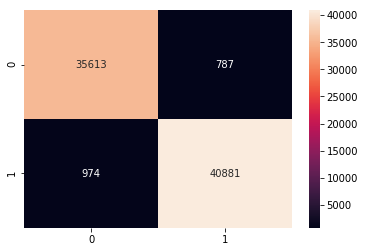

The acuuracy of the model = TP+TN/(TP+TN+FP+FN) =  0.977496645581752 
 The Missclassification = 1-Accuracy =  0.022503354418248023 
 Sensitivity or True Positive Rate = TP/(TP+FN) =  0.9767291840879226 
 Specificity or True Negative Rate = TN/(TN+FP) =  0.9783791208791209 
 Positive Predictive value = TP/(TP+FP) =  0.9811126043966593 
 Negative predictive Value = TN/(TN+FN) =  0.9733785224259983 
 Positive Likelihood Ratio = Sensitivity/(1-Specificity) =  45.17527611283415 
 Negative likelihood Ratio = (1-Sensitivity)/Specificity =  0.023785070036211938


In [36]:
#perform log reg and analyse results ...
print(X_scaled.shape, " ", X_test_scaled.shape )
y_true, y_predict, model_lr = logistic(X_train_v, X_test_v, y_train, y_test, C=best_parameters['clf__C'],
                             max_iter=best_parameters['clf__max_iter'])
print("y_true.shape; ", y_true.shape, " y_predict.shape; ", y_predict.shape)
print("roc score; ", roc_auc_score(y_true, y_predict))

fpr, tpr, thresholds = metrics.roc_curve(y_true, y_predict)
print([fpr, tpr, thresholds])
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("optimal_threshold: ", optimal_threshold)

# use the above optimal_threshold to calculate new y_predict, calculate confusion matrix and model_stats
y_predict_val = [1 if i >= optimal_threshold else 0 for i in y_predict]

# 0 -> negative, 1 -> positive
tn, fp, fn, tp = confusion_matrix(y_true, y_predict_val).ravel()
conf_mat = confusion_matrix(y_true, y_predict_val)
print("tn: ", tn, "fp: ", fp, "fn: ", fn, "tp: ", tp)
print(conf_mat)
seaborn.heatmap(conf_mat, annot=True, fmt="d")
plt.show()

model_stats(tp, tn, fp, fn)

# Saving the model

In [37]:
from joblib import dump, load
dump(model_lr, 'lr_model_v2.joblib') 

['lr_model_v2.joblib']

In [38]:
dump(vectorizer, 'vectorizer_v2.joblib') 

['vectorizer_v2.joblib']